In [ ]:
'Calculating phylogenetic distances'
'Differences between phylogenetic distance in benign and pathogenic'

(303, 207)
           -5P     -5G     -5A     -5C     -5S     -5T     -5V     -5I  \
AAK1    0.0720  0.0245  0.0284  0.0456  0.0425  0.0425  0.0951  0.1554   
ACVR2A  0.0415  0.0481  0.0584  0.0489  0.0578  0.0578  0.0598  0.0625   
ACVR2B  0.0533  0.0517  0.0566  0.0772  0.0533  0.0533  0.0543  0.0442   
AKT1    0.0603  0.0594  0.0552  0.0605  0.0516  0.0516  0.0427  0.0435   
AKT2    0.0602  0.0617  0.0643  0.0582  0.0534  0.0534  0.0433  0.0418   

           -5L     -5M  ...      4H      4K      4R      4Q      4N      4D  \
AAK1    0.0993  0.0864  ...  0.0560  0.0831  0.0928  0.0635  0.0592  0.0389   
ACVR2A  0.0596  0.0521  ...  0.0573  0.0527  0.0491  0.0616  0.0556  0.0640   
ACVR2B  0.0471  0.0516  ...  0.0561  0.0451  0.0486  0.0585  0.0532  0.0730   
AKT1    0.0464  0.0505  ...  0.0663  0.1145  0.1082  0.0735  0.0649  0.0443   
AKT2    0.0493  0.0513  ...  0.0679  0.1155  0.0990  0.0652  0.0623  0.0362   

            4E      4s      4t      4y  
AAK1    0.0457  0.0251  0.02

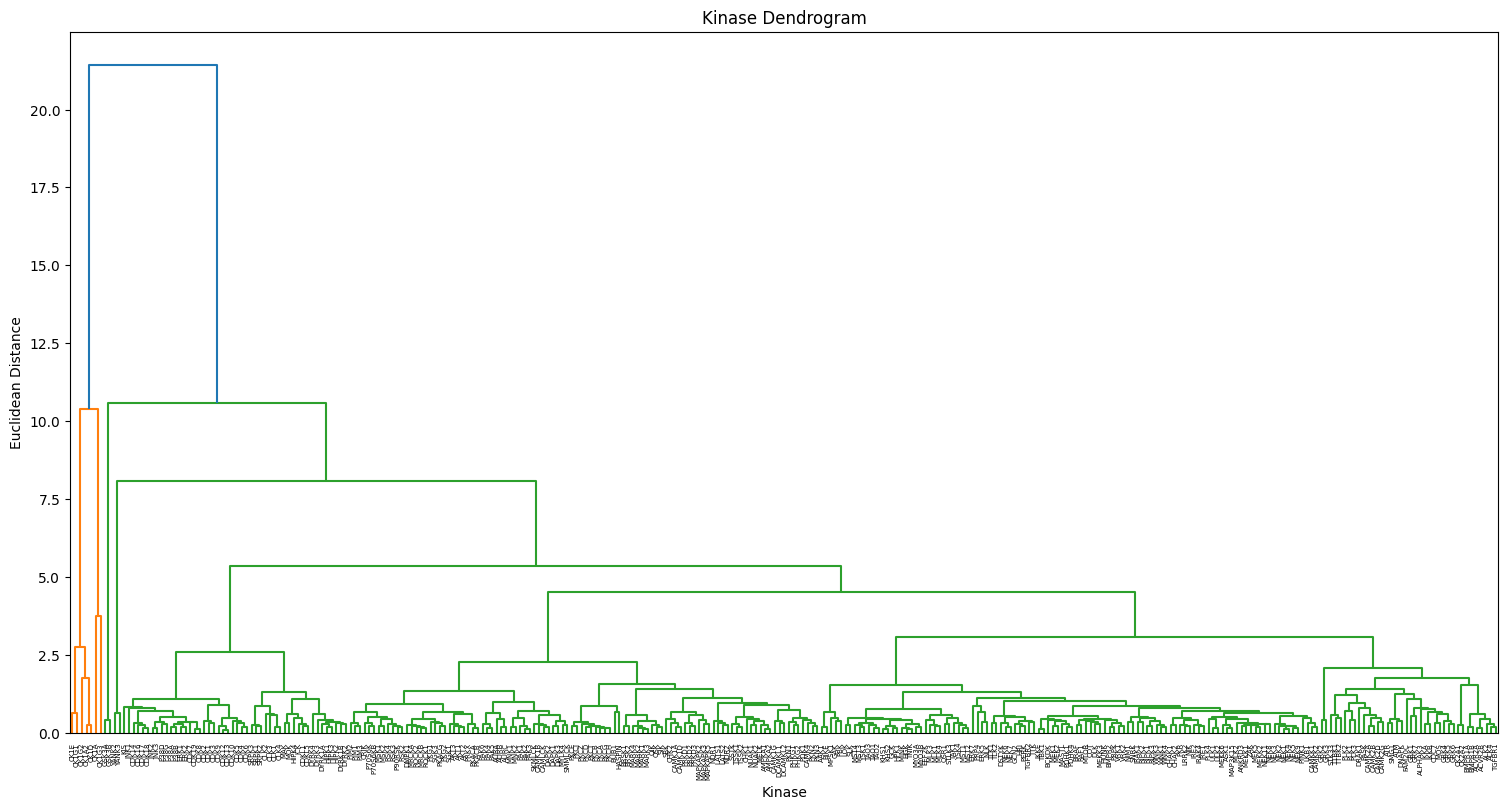

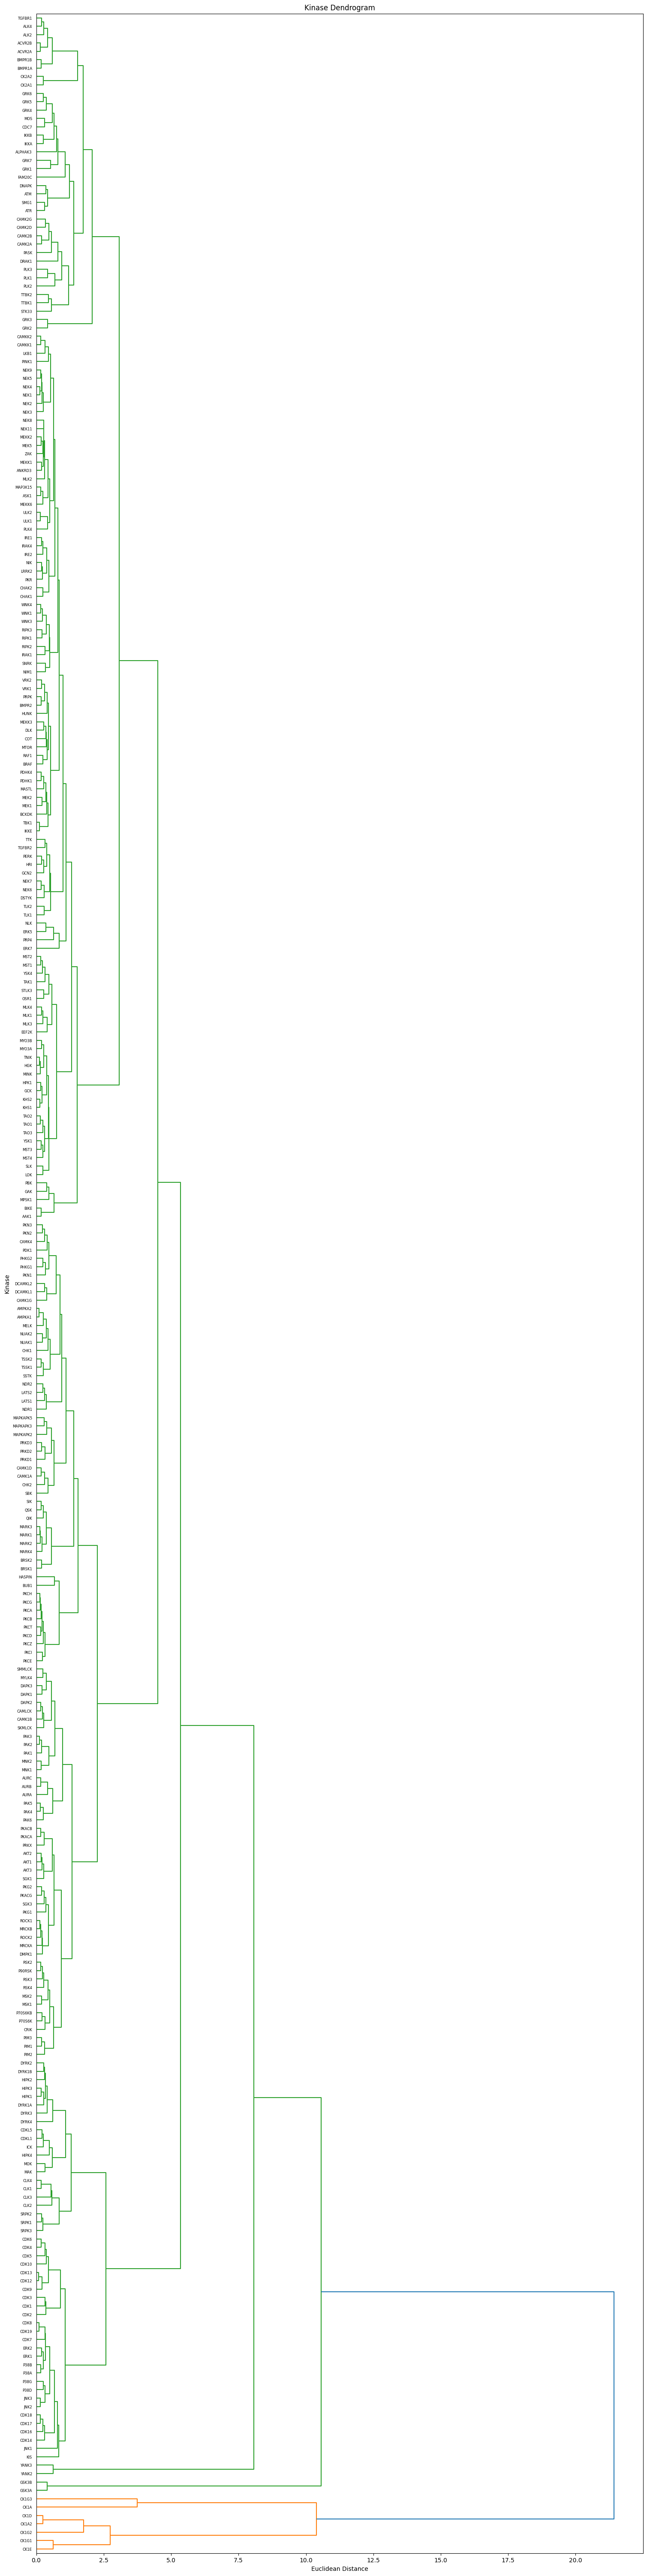

In [9]:
import pandas as pd

ser_thr_matrice_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\ser_thr_all_norm_matrices.csv"
df = pd.read_csv(ser_thr_matrice_path, index_col=0)
print(df.shape)
print(df.head())

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt

# Calculate pairwise distances (Euclidean)
distances = pdist(df.values, metric='euclidean')

# Generate linkage matrix using Ward’s method (as in the paper)
linkage_matrix = linkage(distances, method='ward')

# Optional: visualize dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, labels=df.index.tolist(), leaf_rotation=90)
plt.title("Kinase Dendrogram")
plt.tight_layout()
plt.ylabel("Euclidean Distance")
plt.xlabel("Kinase")
plt.show()
plt.figure(figsize=(15, 60))
dendrogram(
    linkage_matrix,
    labels=df.index.tolist(),
    orientation='right',     # horizontal dendrogram
    leaf_font_size=6
)
plt.title("Kinase Dendrogram")
plt.tight_layout()
plt.xlabel("Euclidean Distance")
plt.ylabel("Kinase")
plt.show()


C:\Users\ricea\AppData\Local\Temp\ipykernel_16504\1728713512.py:86: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_distances, x='Type', y='Distance', palette='Set2')


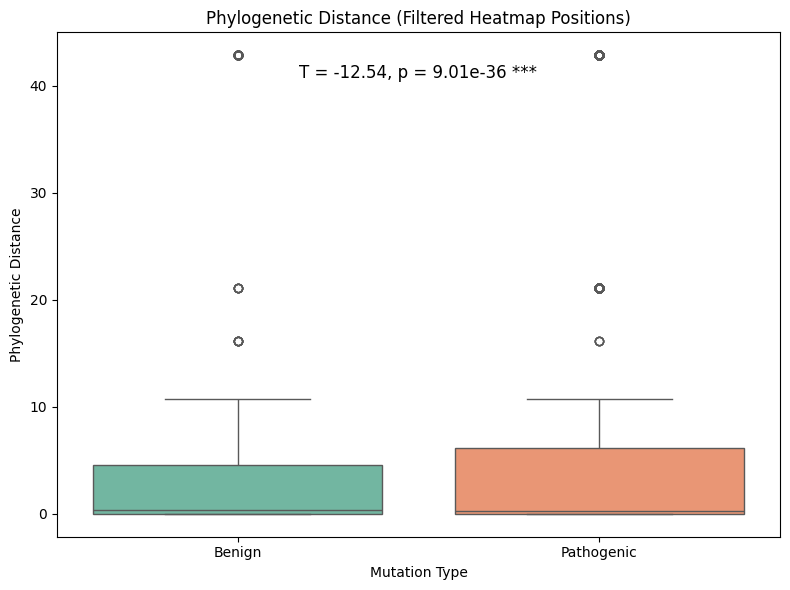

In [1]:
import os
import pandas as pd
from Bio import Phylo
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

# Load the phylogenetic tree
tree = Phylo.read("kinase_tree.nwk", "newick")

# Directories
benign_dir = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\benign_mutations2\mutations2"
pathogenic_dir = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\pathogenic_mutations2\mutations2"

# Helper function to extract top kinase
def get_top_kinase(file_path):
    try:
        df = pd.read_csv(file_path)
        return df.sort_values("Score", ascending=False).iloc[0]["index"]
    except Exception:
        return None

# Master list
records = []

for label, folder in [("Benign", benign_dir), ("Pathogenic", pathogenic_dir)]:
    for file in os.listdir(folder):
        if not file.endswith(".csv"):
            continue

        parts = file.split("_")
        if len(parts) < 4:
            continue

        uniprot, pos, kind = parts[0], parts[1], parts[2]

        # Extract position as integer
        try:
            heatmap_pos = int(file.split("pos")[1].split("_")[0])
        except:
            continue

        # Skip edge positions
        if heatmap_pos in [1, 2, 13, 14, 15]:
            continue

        # Build paths
        full_path = os.path.join(folder, file)
        wildtype_name = f"{uniprot}_{pos}_wildtype.csv"
        wildtype_path = os.path.join(folder, wildtype_name)

        # Ensure wildtype file exists
        if not os.path.exists(wildtype_path):
            continue

        # Get top kinases
        mutant_kinase = get_top_kinase(full_path)
        wildtype_kinase = get_top_kinase(wildtype_path)

        if mutant_kinase and wildtype_kinase:
            try:
                distance = tree.distance(mutant_kinase, wildtype_kinase)
                records.append({
                    "UniProt_ID": uniprot,
                    "Position": pos,
                    "Heatmap_Position": heatmap_pos,
                    "WT_Kinase": wildtype_kinase,
                    "Mut_Kinase": mutant_kinase,
                    "Distance": distance,
                    "Type": label
                })
            except:
                continue

# Save dataframe
df_distances = pd.DataFrame(records)
df_distances.to_csv("phylo_distances_filtered.csv", index=False)

# Run t-test
benign = df_distances[df_distances["Type"] == "Benign"]["Distance"]
pathogenic = df_distances[df_distances["Type"] == "Pathogenic"]["Distance"]
t_stat, p_val = ttest_ind(benign, pathogenic, equal_var=False)

# Plot boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_distances, x='Type', y='Distance', palette='Set2')
plt.title('Phylogenetic Distance (Filtered Heatmap Positions)')
plt.ylabel('Phylogenetic Distance')
plt.xlabel('Mutation Type')

# Determine significance label
significance = ""
if p_val < 0.001:
    significance = "***"
elif p_val < 0.01:
    significance = "**"
elif p_val < 0.05:
    significance = "*"

# Annotate with stats and significance
plt.text(0.5, df_distances['Distance'].max() * 0.95,
         f"T = {t_stat:.2f}, p = {p_val:.2e} {significance}",
         ha='center', fontsize=12)


plt.tight_layout()
plt.savefig("expanded_filtered_phylo_distance_boxplot.png", dpi=300)
plt.show()


Descriptive Statistics:
Benign - Mean: 2.9877, Median: 0.3320
Pathogenic - Mean: 5.0295, Median: 0.2916

Mann-Whitney U Test:
U-statistic = 10769772.00, p-value = 1.9358e-05


C:\Users\ricea\AppData\Local\Temp\ipykernel_16504\315281600.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Type', y='Distance', palette='Set2')


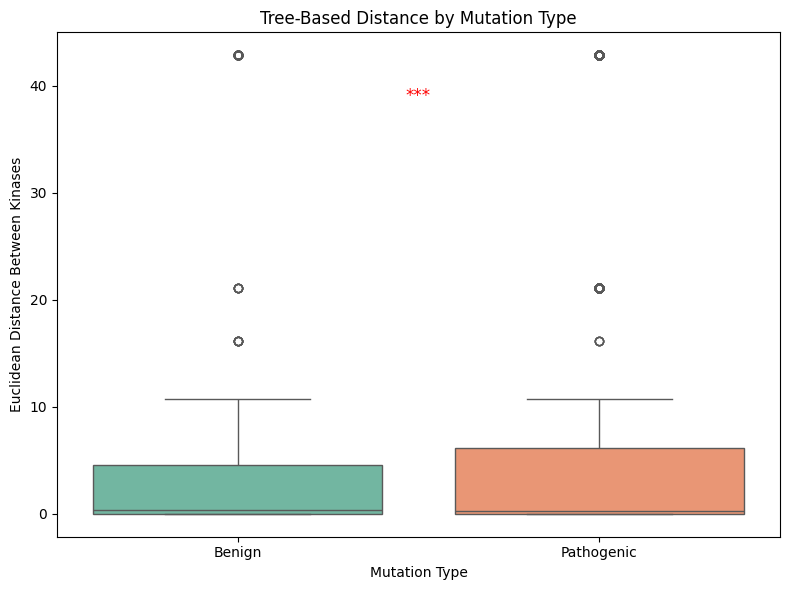

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import os

# Path to your CSV file
csv_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylo_distances_filtered.csv"
output_path = os.path.join(os.path.dirname(csv_path), "filtered_phylo_distance_boxplot.png")

# Load data
df = pd.read_csv(csv_path)

# T-test between groups
benign = df[df["Type"] == "Benign"]["Distance"]
pathogenic = df[df["Type"] == "Pathogenic"]["Distance"]

from scipy.stats import mannwhitneyu

# Calculate descriptive statistics
benign_mean = benign.mean()
benign_median = benign.median()
pathogenic_mean = pathogenic.mean()
pathogenic_median = pathogenic.median()

print("Descriptive Statistics:")
print(f"Benign - Mean: {benign_mean:.4f}, Median: {benign_median:.4f}")
print(f"Pathogenic - Mean: {pathogenic_mean:.4f}, Median: {pathogenic_median:.4f}")

# Mann-Whitney U Test (non-parametric)
u_stat, mw_p_val = mannwhitneyu(benign, pathogenic, alternative='two-sided')

print("\nMann-Whitney U Test:")
print(f"U-statistic = {u_stat:.2f}, p-value = {mw_p_val:.4e}")

t_stat, p_val = ttest_ind(benign, pathogenic, equal_var=False)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Type', y='Distance', palette='Set2')
plt.title('Tree-Based Distance by Mutation Type')
plt.ylabel('Euclidean Distance Between Kinases')
plt.xlabel('Mutation Type')

# Determine significance label
significance = ""
if p_val < 0.001:
    significance = "***"
elif p_val < 0.01:
    significance = "**"
elif p_val < 0.05:
    significance = "*"

# Annotate with stats and significance
plt.text(0.5, df_distances['Distance'].max() * 0.9,
         f"{significance}",
         ha='center', fontsize=12, color="red")

plt.tight_layout()
plt.savefig(output_path, dpi=300)
plt.show()


In [14]:
# Sample sizes
benign_n = len(benign)
pathogenic_n = len(pathogenic)

print(f"Sample Sizes:")
print(f"Benign: {benign_n}")
print(f"Pathogenic: {pathogenic_n}")


Sample Sizes:
Benign: 4438
Pathogenic: 5095


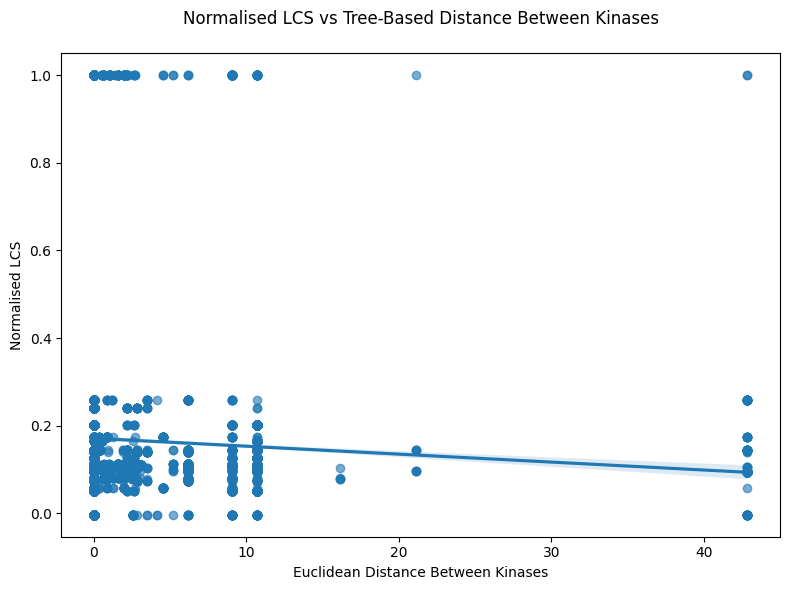

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

# Load phylogenetic distance data (already filtered)
csv_path = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylo_distances_filtered.csv"
df_dist = pd.read_csv(csv_path)
df_dist = df_dist.rename(columns={"Position": "Amino_acid_position"})  

# Load mutation metadata (contains LCS_Ratio)
df_lcs = pd.read_csv("all_LCS_values.csv")

# Merge on UniProt_ID and Amino_acid_position
merged = pd.merge(
    df_dist,
    df_lcs[["UniProt_ID", "Amino_acid_position", "LCS_Ratio"]],
    on=["UniProt_ID", "Amino_acid_position"],
    how="inner"
)

# Filter for heatmap positions 3 to 12 (inclusive)
merged = merged[(merged["Heatmap_Position"] >= 3) & (merged["Heatmap_Position"] <= 12)]

# Drop any missing values
merged = merged.dropna(subset=["Distance", "LCS_Ratio"])

# Correlation
pearson_corr, pearson_p = pearsonr(merged["LCS_Ratio"], merged["Distance"])
spearman_corr, spearman_p = spearmanr(merged["LCS_Ratio"], merged["Distance"])

# Plot
plt.figure(figsize=(8, 6))
sns.regplot(data=merged, x="Distance", y="LCS_Ratio", scatter_kws={'alpha':0.6})
plt.title(f"Normalised LCS vs Tree-Based Distance Between Kinases\n"
)
plt.xlabel("Euclidean Distance Between Kinases")
plt.ylabel("Normalised LCS")
plt.tight_layout()
plt.savefig("LCS_vs_phylo_distance_filtered_pos3-12.png", dpi=300)
plt.show()


In [15]:
# Summary statistics
print("=== Summary Statistics ===")
for col in ["Distance", "LCS_Ratio"]:
    print(f"\n--- {col} ---")
    print(f"Mean: {merged[col].mean():.4f}")
    print(f"Median: {merged[col].median():.4f}")
    print(f"Standard Deviation: {merged[col].std():.4f}")
    print(f"Sample Size: {merged[col].count()}")

# If 'Type' column exists, show group-wise stats
if "Type" in merged.columns:
    print("\n=== Grouped by Mutation Type ===")
    grouped_stats = merged.groupby("Type")[["Distance", "LCS_Ratio"]].agg(["mean", "median", "std", "count"])
    print(grouped_stats)

# Correlation results
print("\n=== Correlation Statistics ===")
print(f"Pearson correlation: r = {pearson_corr:.4f}, p = {pearson_p:.3g}")
print(f"Spearman correlation: ρ = {spearman_corr:.4f}, p = {spearman_p:.3g}")


=== Summary Statistics ===

--- Distance ---
Mean: 4.0875
Median: 0.0000
Standard Deviation: 7.0700
Sample Size: 9397

--- LCS_Ratio ---
Mean: 0.1639
Median: 0.1100
Standard Deviation: 0.2069
Sample Size: 9397

=== Grouped by Mutation Type ===
            Distance                        LCS_Ratio                      \
                mean median       std count      mean    median       std   
Type                                                                        
Benign      3.088912    0.0  6.385281  2056  0.243046  0.110032  0.340861   
Pathogenic  4.367116    0.0  7.225880  7341  0.141690  0.110032  0.141425   

                  
           count  
Type              
Benign      2056  
Pathogenic  7341  

=== Correlation Statistics ===
Pearson correlation: r = -0.0619, p = 1.89e-09
Spearman correlation: ρ = -0.0025, p = 0.811


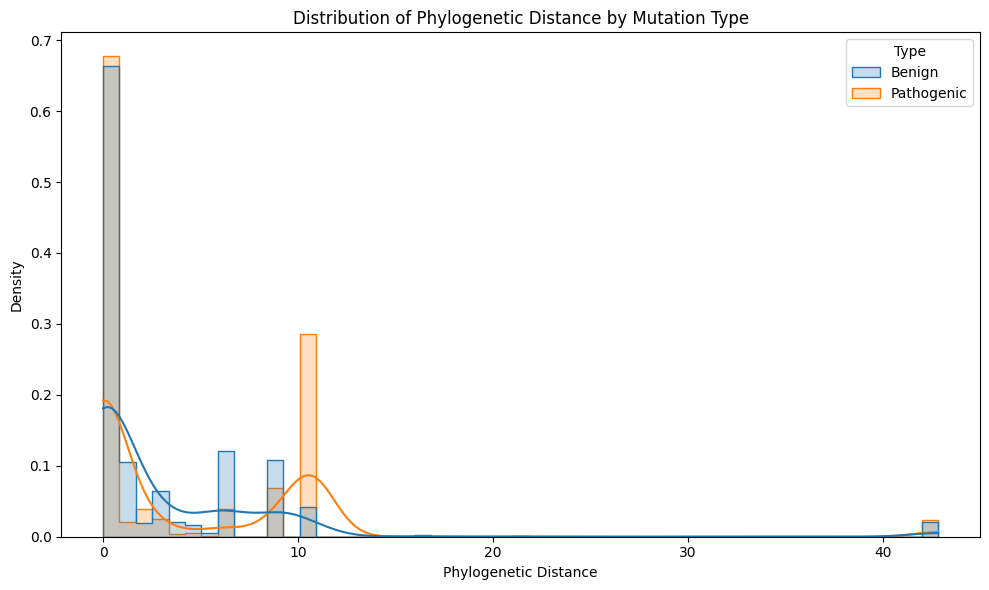

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(data=merged, x="Distance", hue="Type", element="step", stat="density", common_norm=False, kde=True)
plt.title("Distribution of Phylogenetic Distance by Mutation Type")
plt.xlabel("Phylogenetic Distance")
plt.ylabel("Density")
plt.tight_layout()
plt.show()


C:\Users\ricea\AppData\Local\Temp\ipykernel_16504\655969159.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=merged, x="Type", y="Distance", palette="Set2", inner="quartile", scale="width", cut=0)
C:\Users\ricea\AppData\Local\Temp\ipykernel_16504\655969159.py:5: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=merged, x="Type", y="Distance", palette="Set2", inner="quartile", scale="width", cut=0)


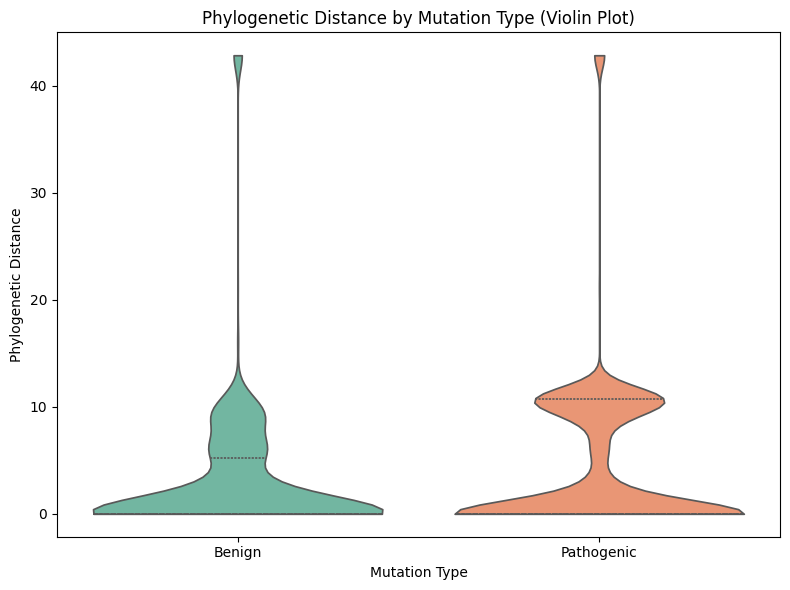

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.violinplot(data=merged, x="Type", y="Distance", palette="Set2", inner="quartile", scale="width", cut=0)
plt.title("Phylogenetic Distance by Mutation Type (Violin Plot)")
plt.xlabel("Mutation Type")
plt.ylabel("Phylogenetic Distance")
plt.tight_layout()
plt.show()


In [ ]:
'Specific mutation - all data points'

C:\Users\ricea\AppData\Local\Temp\ipykernel_9024\2440987795.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x='Type_y', y='Distance',


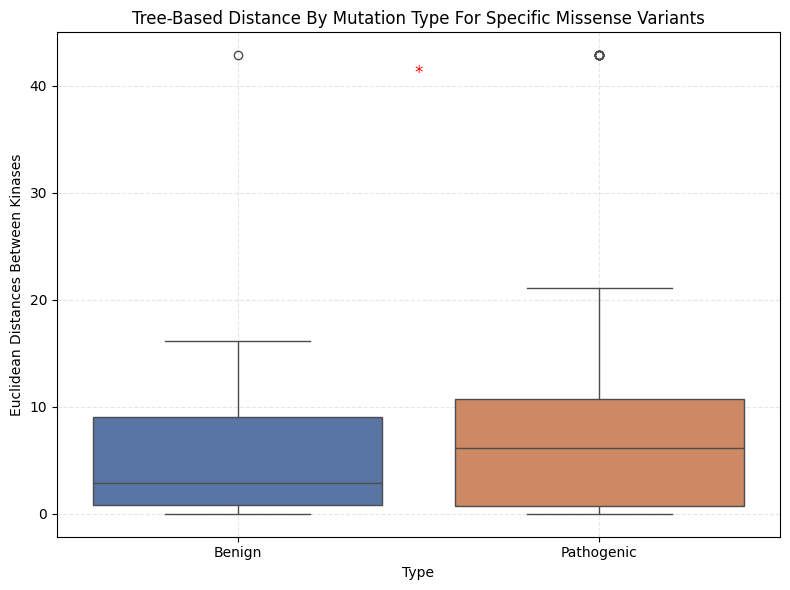

✅ Analysis complete. Files saved to:
- C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\merged_phylo_data.csv
- C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylogenetic_distance_boxplot_from_filtered.png
- C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylo_distance_stats_filtered.csv


In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import os

# File paths
input_excel = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\Statistics_Input.xlsx"
distance_csv = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylo_distances_filtered.csv"

# Output folder
output_folder = os.path.dirname(input_excel)

# Load files
df_input = pd.read_excel(input_excel)
df_distances = pd.read_csv(distance_csv)

# Normalize column types
df_input["Amino_acid_position"] = df_input["Amino_acid_position"].astype(int)
df_input["Reference_Position"] = df_input["Reference_Position"].astype(int)
df_input["Heatmap_Position"] = df_input["Heatmap_Position"].astype(int)
df_distances["Position"] = df_distances["Position"].astype(int)
df_distances["Heatmap_Position"] = df_distances["Heatmap_Position"].astype(int)

# Try merging on Amino_acid_position
merge_aa = pd.merge(df_input, df_distances,
                    how="inner",
                    left_on=["UniProt_ID", "Amino_acid_position", "Heatmap_Position"],
                    right_on=["UniProt_ID", "Position", "Heatmap_Position"])

# Try merging on Reference_Position
merge_ref = pd.merge(df_input, df_distances,
                     how="inner",
                     left_on=["UniProt_ID", "Reference_Position", "Heatmap_Position"],
                     right_on=["UniProt_ID", "Position", "Heatmap_Position"])

# Combine and drop duplicates
df_merged = pd.concat([merge_aa, merge_ref], ignore_index=True).drop_duplicates()

# Save merged data
merged_path = os.path.join(output_folder, "merged_phylo_data.csv")
df_merged.to_csv(merged_path, index=False)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_merged, x='Type_y', y='Distance',
            order=['Benign', 'Pathogenic'],
            palette={'Benign': '#4c72b0', 'Pathogenic': '#dd8452'})
plt.title('Phylogenetic Distance of Mutant vs Wild-Type Kinases')
plt.grid(True, linestyle='--', alpha=0.3)

# Run t-test
benign = df_merged[df_merged["Type_y"] == "Benign"]["Distance"]
pathogenic = df_merged[df_merged["Type_y"] == "Pathogenic"]["Distance"]

t_stat, p_val = ttest_ind(benign, pathogenic, equal_var=False)

# Add significance annotation
significance = ""
if p_val < 0.001: significance = "***"
elif p_val < 0.01: significance = "**"
elif p_val < 0.05: significance = "*"

plt.text(0.5, df_merged['Distance'].max() * 0.95,
         f"{significance}",
         ha='center', fontsize=12, color='red',
)

# Save plot and stats
plt.tight_layout()
plt.savefig(os.path.join(output_folder, "phylogenetic_distance_boxplot_from_filtered.png"), dpi=300)
plt.ylabel("Euclidean Distances Between Kinases")
plt.xlabel("Type")
plt.title("Tree-Based Distance By Mutation Type For Specific Missense Variants")
plt.show()

# Save t-test results
stats_output = pd.DataFrame([{
    'Benign_Count': len(benign),
    'Pathogenic_Count': len(pathogenic),
    'Benign_Mean': benign.mean(),
    'Pathogenic_Mean': pathogenic.mean(),
    'T_stat': t_stat,
    'P_value': p_val
}])
stats_output.to_csv(os.path.join(output_folder, "phylo_distance_stats_filtered.csv"), index=False)

print("✅ Analysis complete. Files saved to:")
print(f"- {merged_path}")
print(f"- {output_folder}\\phylogenetic_distance_boxplot_from_filtered.png")
print(f"- {output_folder}\\phylo_distance_stats_filtered.csv")



In [ ]:
'Specific variants - mean distance'

Expected pathogenic mutations: 46
Unique pathogenic mutations after merging: 40
Pathogenic mutations missing distance data: 5


C:\Users\ricea\AppData\Local\Temp\ipykernel_9024\2184011836.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_grouped, x='Type', y='Distance',


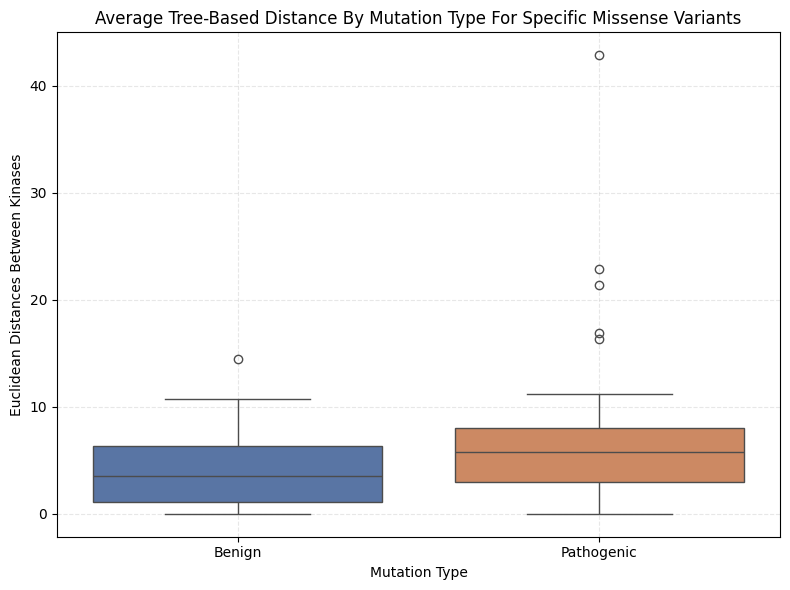

✅ Analysis complete. Files saved to:
- Merged raw data: C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\merged_phylo_data.csv
- Grouped data: C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\grouped_phylo_data.csv
- Boxplot: C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylogenetic_distance_boxplot_filtered_grouped.png
- Stats CSV: C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylo_distance_stats_filtered_grouped.csv


In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import os

# File paths
input_excel = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\Statistics_Input.xlsx"
distance_csv = r"C:\Users\ricea\OneDrive\Documents\GitHub\Annabel-BSc-Project\Phylogenetic Distances\phylo_distances_filtered.csv"

# Output folder
output_folder = os.path.dirname(input_excel)

# Load files
df_input = pd.read_excel(input_excel)
df_distances = pd.read_csv(distance_csv)

# Normalize column types
df_input["Amino_acid_position"] = df_input["Amino_acid_position"].astype(int)
df_input["Reference_Position"] = df_input["Reference_Position"].astype(int)
df_input["Heatmap_Position"] = df_input["Heatmap_Position"].astype(int)
df_distances["Position"] = df_distances["Position"].astype(int)
df_distances["Heatmap_Position"] = df_distances["Heatmap_Position"].astype(int)

# Try merging on Amino_acid_position
merge_aa = pd.merge(df_input, df_distances,
                    how="inner",
                    left_on=["UniProt_ID", "Amino_acid_position", "Heatmap_Position"],
                    right_on=["UniProt_ID", "Position", "Heatmap_Position"])

# Try merging on Reference_Position
merge_ref = pd.merge(df_input, df_distances,
                     how="inner",
                     left_on=["UniProt_ID", "Reference_Position", "Heatmap_Position"],
                     right_on=["UniProt_ID", "Position", "Heatmap_Position"])

# Combine and drop duplicates
df_merged = pd.concat([merge_aa, merge_ref], ignore_index=True).drop_duplicates()

# Save raw merged data
merged_path = os.path.join(output_folder, "merged_phylo_data.csv")
df_merged.to_csv(merged_path, index=False)

# Count unique pathogenic mutations expected from input
expected_pathogenic = df_input[df_input["Type"].str.lower() == "pathogenic"]
print("Expected pathogenic mutations:", expected_pathogenic.shape[0])

# Count unique pathogenic mutations after merging and grouping
unique_pathogenic = df_merged[df_merged["Type_y"].str.lower() == "pathogenic"].groupby(
    ["UniProt_ID", "Amino_acid_change"]).size().shape[0]
print("Unique pathogenic mutations after merging:", unique_pathogenic)

# Check if any pathogenic mutations are missing distances:
missing_pathogenic = expected_pathogenic.merge(
    df_merged[df_merged["Type_y"].str.lower() == "pathogenic"],
    how='left', 
    on=["UniProt_ID", "Amino_acid_change"]
)
missing_count = missing_pathogenic['Distance'].isna().sum()
print(f"Pathogenic mutations missing distance data: {missing_count}")


# GROUP to get 1 distance per mutation (mean distance if multiple matches)
df_grouped = df_merged.groupby(
    ["UniProt_ID", "Amino_acid_change", "Type_x"]
)["Distance"].mean().reset_index()
df_grouped = df_grouped.rename(columns={"Type_x": "Type"})

# Save grouped data
grouped_path = os.path.join(output_folder, "grouped_phylo_data.csv")
df_grouped.to_csv(grouped_path, index=False)

# Plot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_grouped, x='Type', y='Distance',
            order=['Benign', 'Pathogenic'],
            palette={'Benign': '#4c72b0', 'Pathogenic': '#dd8452'})
plt.ylabel("Euclidean Distances Between Kinases")
plt.xlabel("Mutation Type")
plt.title("Average Tree-Based Distance By Mutation Type For Specific Missense Variants")
plt.grid(True, linestyle='--', alpha=0.3)

# Run t-test
benign = df_grouped[df_grouped["Type"] == "Benign"]["Distance"]
pathogenic = df_grouped[df_grouped["Type"] == "Pathogenic"]["Distance"]

t_stat, p_val = ttest_ind(benign, pathogenic, equal_var=False)

# Add significance annotation
significance = ""
if p_val < 0.001:
    significance = "***"
elif p_val < 0.01:
    significance = "**"
elif p_val < 0.05:
    significance = "*"

plt.text(0.5, df_grouped['Distance'].max() * 0.95,
         f"{significance}",
         ha='center', fontsize=12)

# Save plot and stats
plt.tight_layout()
plot_path = os.path.join(output_folder, "phylogenetic_distance_boxplot_filtered_grouped.png")
plt.savefig(plot_path, dpi=300)
plt.show()

# Save t-test results
stats_output = pd.DataFrame([{
    'Benign_Count': len(benign),
    'Pathogenic_Count': len(pathogenic),
    'Benign_Mean': benign.mean(),
    'Pathogenic_Mean': pathogenic.mean(),
    'T_stat': t_stat,
    'P_value': p_val
}])
stats_path = os.path.join(output_folder, "phylo_distance_stats_filtered_grouped.csv")
stats_output.to_csv(stats_path, index=False)

# Final confirmation
print("✅ Analysis complete. Files saved to:")
print(f"- Merged raw data: {merged_path}")
print(f"- Grouped data: {grouped_path}")
print(f"- Boxplot: {plot_path}")
print(f"- Stats CSV: {stats_path}")


In [12]:
# Print summary statistics
print("\n📊 Summary Statistics:")
print(f"Benign count:      {len(benign)}")
print(f"Pathogenic count:  {len(pathogenic)}")
print(f"Benign mean:       {benign.mean():.4f}")
print(f"Pathogenic mean:   {pathogenic.mean():.4f}")
print(f"T-statistic:       {t_stat:.4f}")
print(f"P-value:           {p_val:.4e}")

# Optional: significance interpretation
if significance:
    print(f"Statistical significance: {significance} (based on p-value)")
else:
    print("No statistically significant difference (p ≥ 0.05)")



📊 Summary Statistics:
Benign count:      20
Pathogenic count:  40
Benign mean:       4.4034
Pathogenic mean:   7.4097
T-statistic:       -1.9236
P-value:           5.9360e-02
No statistically significant difference (p ≥ 0.05)


In [22]:
from scipy.stats import mannwhitneyu

# Run Mann–Whitney U test
u_stat, p_val = mannwhitneyu(benign, pathogenic, alternative="two-sided")

# Print results
print("Mann–Whitney U Test Results")
print(f"U statistic: {u_stat:.3f}")
print(f"P-value: {p_val:.3e}")
print(f"Benign (n={len(benign)}), mean distance = {benign.mean():.3f}")
print(f"Pathogenic (n={len(pathogenic)}), mean distance = {pathogenic.mean():.3f}")


Mann–Whitney U Test Results
U statistic: 287.000
P-value: 7.760e-02
Benign (n=20), mean distance = 4.403
Pathogenic (n=40), mean distance = 7.410
